In [1]:
import keras.losses
import numpy as np
import pandas as pd
from pydicom import dcmread
import pydicom.pixel_data_handlers
import nibabel as nib
import os
import tensorflow as tf
import tensorflow_io as tfio
from keras.layers import CategoryEncoding, IntegerLookup
import matplotlib.pyplot as plt
import re

CURRENT_DIR_PATH = os.getcwd()

TRAIN_IMAGE_PATH = os.path.join(CURRENT_DIR_PATH, "train_images")
SEGMENTATIONS_PATH = os.path.join(CURRENT_DIR_PATH, "segmentations")
TRAIN_CSV_PATH = os.path.join(CURRENT_DIR_PATH, "train.csv")

AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 75

2022-10-05 20:26:00.964992: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-05 20:26:00.965010: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]

def pad_list(labels_to_pad):
    return [labels_to_pad[len(labels_to_pad) - 1] if i >= len(labels_to_pad) else labels_to_pad[i] for i in range(0, 8)]

def create_categories(labels_for_categories):
    vocab = [1, 2, 3, 4, 5, 6, 7]
    index = IntegerLookup(vocabulary=vocab)
    encoder = CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode='multi_hot')
    categories = encoder(index(labels_for_categories))

    return categories

def decode_img(path):
    with open(path, 'rb') as image_file:
        ds = dcmread(image_file)
        img = ds.pixel_array
        img = img / 255
        img = tf.reshape(img, [512, 512, 1])

    return img

def labels_for_image(vertebrae):
    vertebrae_for_image = list(filter(lambda vertebra: vertebra > 0, vertebrae))
    labels_to_pad = list((map(lambda vertebra: int(vertebra), vertebrae_for_image))) if len(vertebrae_for_image) > 0 else [0]
    padded_labels = pad_list(labels_to_pad)
    return create_categories(padded_labels)

def preprocess_data():
    segmentation_patient_files = os.listdir(SEGMENTATIONS_PATH)
    train_images = []
    train_image_labels = []

    for segmentation_patient_file in segmentation_patient_files:
        file_path = os.path.join(SEGMENTATIONS_PATH, segmentation_patient_file)
        segmentation_file = nib.load(file_path).get_fdata()
        segmentation_file_transposed = segmentation_file[:, ::-1, ::-1].transpose(2, 1, 0)

        for slice_number in range(0, len(segmentation_file_transposed)):
            dicom_slice = segmentation_file_transposed[slice_number]
            vertebrae = np.unique(dicom_slice)
            labels = labels_for_image(vertebrae)
            train_image_labels.append(labels)
            train_images_path = os.path.join(TRAIN_IMAGE_PATH, file_path.split("/")[-1].replace('.nii', ""))
            image_dir = os.listdir(train_images_path)
            image_dir.sort(key=natural_keys)
            image_path = os.path.join(train_images_path, image_dir[slice_number])
            decoded_image = decode_img(image_path)
            train_images.append(decoded_image)

     # categories = create_categories(train_image_labels)
    dataset_size = len(train_images)
    val_size = int(dataset_size * 0.2)
    x_t = train_images[val_size:]
    y_t = train_image_labels[val_size:]

    x_v = train_images[:val_size]
    y_v = train_image_labels[:val_size]

    return x_t, y_t, x_v, y_v

x_train, y_train, x_val, y_val = preprocess_data()

2022-10-05 20:26:09.404582: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-05 20:26:09.404603: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-05 20:26:09.404618: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cbarb15-desktop): /proc/driver/nvidia/version does not exist
2022-10-05 20:26:09.404923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def create_dataset(filepaths, labels, is_training=True):

    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    if is_training:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=len(filepaths))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

train_ds = create_dataset(x_train, y_train)
val_ds = create_dataset(x_val, y_val)

2022-10-05 20:26:28.215638: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1417674752 exceeds 10% of free system memory.


In [ ]:
for feature, label in train_ds.take(1):
    print(f'Feature {feature}')
    print(f'Feature shape {feature.shape}')
    print(f'Label {label}')
    print(f'Label shape {label.shape}')

In [4]:
from keras import Sequential
import keras.layers as layers
from tensorflow import keras

def create_model():
    # seq_model = Sequential([
    #     layers.Conv2D(64, 7, padding='same', activation='relu', input_shape=(512, 512, 1)),
    #     layers.MaxPooling2D(),
    #     layers.Conv2D(128, 3, padding='same', activation='relu'),
    #     layers.Conv2D(128, 3, padding='same', activation='relu'),
    #     layers.MaxPooling2D(),
    #     layers.Conv2D(256, 3, padding='same', activation='relu'),
    #     layers.Conv2D(256, 3, padding='same', activation='relu'),
    #     layers.MaxPooling2D(),
    #     layers.Flatten(),
    #     layers.Dense(128, activation='relu'),
    #     layers.Dropout(0.5),
    #     layers.Dense(64, activation='relu'),
    #     layers.Dropout(0.5),
    #     layers.Dense(8, activation='sigmoid')
    # ])
    seq_model = Sequential([
        layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(512, 512, 1)),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(8, activation='sigmoid')
    ])

    return seq_model

model = create_model()
model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()
# optimizer = keras.optimizers.SGD(learning_rate=0.001)
# loss_fn = keras.losses.BinaryCrossentropy()
# loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 64)       0

In [5]:
import time

epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

2022-10-05 20:26:43.709867: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1417674752 exceeds 10% of free system memory.


Epoch 1/10


2022-10-05 20:26:44.592791: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1258291200 exceeds 10% of free system memory.
2022-10-05 20:26:48.036742: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1258291200 exceeds 10% of free system memory.


 1/10 [==>...........................] - ETA: 48s - loss: 0.7033 - accuracy: 0.0000e+00

2022-10-05 20:26:49.511737: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1258291200 exceeds 10% of free system memory.


10/10 [==============================] - 44s 4s/step - loss: 3.1681 - accuracy: 0.3698 - val_loss: 0.8351 - val_accuracy: 0.2959
Epoch 2/10
10/10 [==============================] - 43s 4s/step - loss: 0.1082 - accuracy: 0.6420 - val_loss: 0.7340 - val_accuracy: 0.2485
Epoch 3/10
10/10 [==============================] - 42s 4s/step - loss: 0.0261 - accuracy: 0.6775 - val_loss: 1.2467 - val_accuracy: 0.1361
Epoch 4/10
10/10 [==============================] - 41s 4s/step - loss: 0.0382 - accuracy: 0.6213 - val_loss: 1.4319 - val_accuracy: 0.2959
Epoch 5/10
10/10 [==============================] - 43s 4s/step - loss: 0.0160 - accuracy: 0.6790 - val_loss: 1.4447 - val_accuracy: 0.2959
Epoch 6/10
10/10 [==============================] - 43s 4s/step - loss: 0.0088 - accuracy: 0.6672 - val_loss: 1.3152 - val_accuracy: 0.2959
Epoch 7/10
10/10 [==============================] - 42s 4s/step - loss: 0.0427 - accuracy: 0.6686 - val_loss: 0.9651 - val_accuracy: 0.2959
Epoch 8/10
10/10 [=============

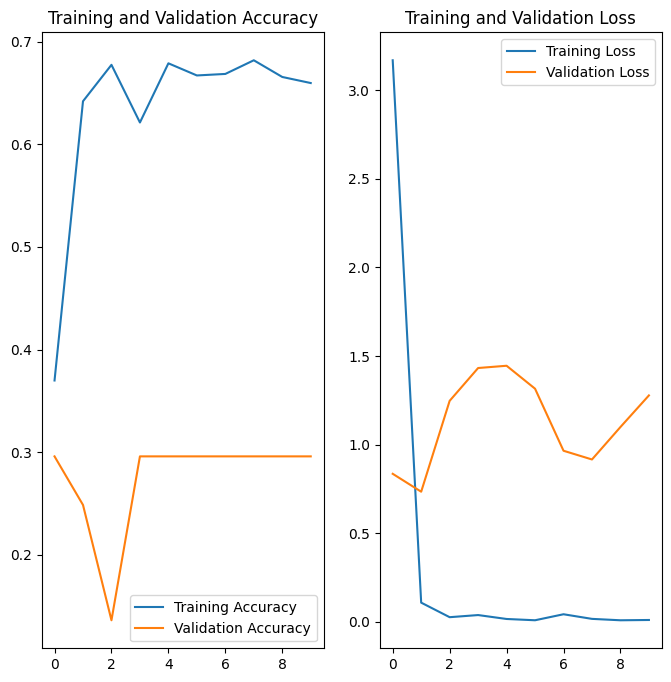

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

# l = loss(model, features, labels, training=False)
# print("Loss test: {}".format(l))

In [ ]:
import random

#  Loss function for training on breaks

def get_weight(key, value):
    is_vertebrae = re.match(r'^C[1-9]$', key)
    if is_vertebrae and value == 0:
        return 1
    elif is_vertebrae and value == 1:
        return 2
    elif key == 'patient_overall' and value == 0:
        return 7
    elif key == 'patient_overall' and value == 1:
        return 14

def loss(patient_id):
    df = pd.read_csv(TRAIN_CSV_PATH)
    patient_row = df.loc[df['StudyInstanceUID'] == patient_id]
    total_loss = 0
    for i in range(1, patient_row.shape[1]):
        key = patient_row.iloc[:, i].name
        y_ij = patient_row.iloc[:, i].values[0]
        w_j = get_weight(key, y_ij)
        p_ij = random.uniform(0, 1)
        total_loss += w_j * (y_ij * np.log(p_ij) + (1 - y_ij) * np.log(1 - p_ij))

    return total_loss

loss('1.2.826.0.1.3680043.780')

In [ ]:
path = os.path.join(CURRENT_DIR_PATH, "flower_photos/daisy")
list_ds = tf.data.Dataset.list_files(str(f'{path}/*.jpg'))

def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

# file_path = next(iter(list_ds))
# image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

images_ds = list_ds.map(parse_image)
for image, label in images_ds.take(2):
    show(image, label)

In [ ]:
# d = tf.data.Dataset.from_tensor_slices(['hello', 'world'])
# def upper_case_fn(t: np.ndarray):
#   return t.decode('utf-8').upper()
# # d = d.map(lambda x: tf.numpy_function(func=upper_case_fn,
# #           inp=[x], Tout=tf.string))
# d = d.map(lambda x: upper_case_fn(x))
# list(d.as_numpy_iterator())

# def add_one(x):
#     return x * 200
#
# dataset = tf.data.Dataset.range(1, 6)  # ==> [ 1, 2, 3, 4, 5 ]
# dataset = dataset.map(add_one)
# list(dataset.as_numpy_iterator())
